In [1]:
#load libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
# text/file processing libraries
import string
import re
import sys
from nltk.corpus import stopwords
from itertools import chain
# warnings
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('./preprocessing/train1.csv')
train_df['text'] = train_df['text'].fillna('')
test_df = pd.read_csv('./preprocessing/test.csv')
test_df['text'] = test_df['text'].fillna('')

In [3]:
from sklearn.model_selection import train_test_split
# split train set into train/validate 
train_df2, validate_df = train_test_split(train_df, test_size=0.075, random_state=0)
train_df2 = train_df2.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

In [5]:
# train and test sets
all_df=pd.concat([train_df,test_df])
X_all = all_df['text']
# training set
X_train = train_df2['text']
y_train = train_df2['target'].astype(int)
# validation set
X_validate= validate_df['text']
y_validate = validate_df['target'].astype(int)
# test set
X_test = test_df['text']

In [6]:
N = len(train_df)
N

6332

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
# create a tokenizer for encoding texts as digits
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# create the tokenizer - mapping data to integer values
tokenizer = create_tokenizer(X_all)
word_index=tokenizer.word_index
max_words = len(word_index) + 1
print( 'unique words are : %d' % max_words)

unique words are : 20936


In [8]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(N,)),
#     tf.keras.layers.Embedding(V+1,D),
#     tf.keras.layers.LSTM(50,return_sequences=True),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(1,activation='sigmoid')
# ])

In [9]:
# tweet with maximum length
max_length = max([len(s.split()) for s in X_all])
print( ' Maximum length: %d ' % max_length)

 Maximum length: 272 


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def encode_data(tokenizer, max_length, data):
    # integer encode
    encoded = tokenizer.texts_to_sequences(data)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding= 'post' )
    return padded
Xtrain = encode_data(tokenizer, max_length, X_train)
Xvalidate = encode_data(tokenizer, max_length, X_validate)
Xtest = encode_data(tokenizer, max_length, X_test)

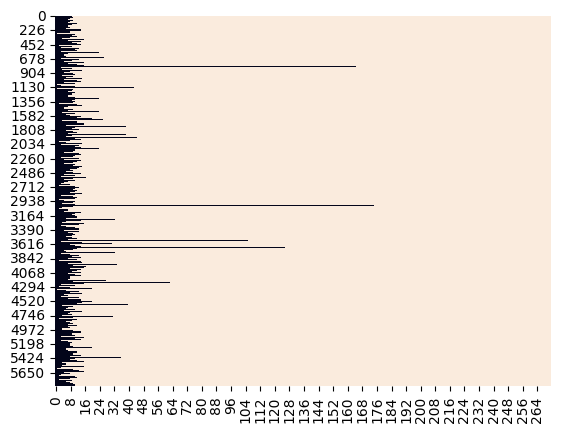

In [11]:
sb.heatmap(Xtrain==0, vmin=0, cbar=False)
plt.show()

In [12]:
embeddings_index = {}
with open('./dataset/glove.6B.100d.txt', 'r',encoding="utf8") as f:
    for line in f:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            continue
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
import  tensorflow.keras.optimizers as optimizers
from tensorflow.keras.layers import LSTM, Bidirectional
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_length))
# lstm layer
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))   
model.add(Bidirectional(LSTM(64,  dropout=0.2, recurrent_dropout=0.2,))) 
# densely connected classifier
model.add(Dense(64, activation= 'relu' ))
model.add(Dense(1, activation='sigmoid'))
# summarize
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 272, 100)          2093600   
                                                                 
 bidirectional (Bidirectiona  (None, 272, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,285,217
Trainable params: 2,285,217
Non-

In [15]:
# load pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [16]:
# compile
model.compile(loss= 'binary_crossentropy',  optimizer=optimizers.Adam(learning_rate=.0001), metrics=[ 'accuracy' ])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.25, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_lstm.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
model.fit(Xtrain, y_train, epochs=10, callbacks=callbacks, validation_data=(Xvalidate,y_validate))

Epoch 1/10
184/184 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6969
Epoch 1: val_loss improved from inf to 0.48273, saving model to model_lstm.h5
184/184 [==============================] - 297s 2s/step - loss: 0.5936 - accuracy: 0.6969 - val_loss: 0.4827 - val_accuracy: 0.7874 - lr: 1.0000e-04
Epoch 2/10
184/184 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.7862
Epoch 2: val_loss improved from 0.48273 to 0.46769, saving model to model_lstm.h5
184/184 [==============================] - 230s 1s/step - loss: 0.4766 - accuracy: 0.7862 - val_loss: 0.4677 - val_accuracy: 0.8084 - lr: 1.0000e-04
Epoch 3/10
184/184 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.8004
Epoch 3: val_loss improved from 0.46769 to 0.42938, saving model to model_lstm.h5
184/184 [==============================] - 250s 1s/step - loss: 0.4542 - accuracy: 0.8004 - val_loss: 0.4294 - val_accuracy: 0.8168 - lr: 1.0000e-04
Epoch 4/10
184/184 [===

In [19]:
model.predict(Xtest)
predictions = model.predict(Xtest)
predictions = predictions.reshape(1,-1)
predictions = predictions[0]
predictions = list(map(lambda x: 1 if x>=0.5 else 0,predictions))

102/102 [==============================] - 20s 196ms/step


In [20]:
from sklearn.metrics import accuracy_score

ans = pd.read_csv('./dataset/ans.csv')['target'].values
accuracy_score(y_pred= predictions, y_true= ans)

0.7646337726019001